In [1]:

from MalardClient.MalardClient import MalardClient
from MalardClient.DataSet import DataSet
from MalardClient.BoundingBox import BoundingBox

from osgeo import ogr, osr
from datetime import datetime

import numpy as np

client = MalardClient()
ds = DataSet( "mtngla", "tdx", "himalayas"  )

proj4 = client.getProjection(ds).proj4

shapeFile = "/data/puma1/scratch/mtngla/karakoram/Karakoram_TDM_XY.shp"

drv = ogr.GetDriverByName('ESRI Shapefile') #We will load a shape file
ds_in = drv.Open(shapeFile)    #Get the contents of the shape file
lyr_in = ds_in.GetLayer(0)    #Get the shape file's first layer

def check(x, y):
    #Create a point
    pt = ogr.Geometry(ogr.wkbPoint)
    pt.SetPoint_2D(0, x, y)

    #Set up a spatial filter such that the only features we see when we
    #loop through "lyr_in" are those which overlap the point defined above
    lyr_in.SetSpatialFilter(pt)

    #Loop through the overlapped features and display the field of interest
    if lyr_in.GetFeatureCount() > 0:
        return True
    else:
        return False
    
def applyMask( xSrs, ySrs ):
    withinMask = np.zeros( len(xSrs) )
    
    for i, xy in enumerate(zip(xSrs, ySrs)):
        x,y = xy
        withinMask[i] = 1 if check(x,y) else 0
        
    return withinMask


In [2]:
minX, maxX, minY, maxY = lyr_in.GetExtent()
minT = datetime(2019,1,1,0,0)
maxT = datetime(2019,1,30,23,59)

bb = BoundingBox(minX, maxX, minY, maxY, minT, maxT )

start =datetime.now()
resultInfo = client.executeQuery(ds, bb )
postQuery = datetime.now()
df = resultInfo.to_df
postDf = datetime.now()
mask = applyMask(df['x'],df['y'])
postMask = datetime.now()
df['withinMask'] = mask

print("Started With {} points. Finished with {}".format(len(df),df['withinMask'].sum()))

totalDiff = (postMask - start).total_seconds()
totalMask = (postMask - postDf).total_seconds()
totalDf = (postDf - postQuery).total_seconds()
totalQuery = (postQuery - start).total_seconds()

print("Masking took {} in total, {} to query, {} to build df, {} to mask".format(totalDiff, totalQuery, totalDf, totalMask))

Started With 2390745 points. Finished with 1532567.0
Masking took 41.597126 in total, 9.216839 to query, 1.169525 to build df, 31.210762 to mask


In [3]:
gcs = client.gridCells(ds,bb)

print(len(gcs))


def checkGCInExtent( gc ):
    if check(gc.minX,gc.minY) or check(gc.minX,gc.maxY) or check(gc.maxX,gc.maxY) or check(gc.minX,gc.minY):
        return True
    else:
        return False

def completelyInsideExtent(gc):
    if check(gc.minX,gc.minY) and check(gc.minX,gc.maxY) and check(gc.maxX,gc.maxY) and check(gc.minX,gc.minY):
        return True
    else:
        return False
    
inextent = [ gc for gc in gcs if checkGCInExtent(gc) ]

print(len(inextent))

compinextent = [ gc for gc in inextent if not completelyInsideExtent(gc) ]

print(len(compinextent))

totalPoints = [ gc.numberOfPoints for gc in gcs ]

print(sum(totalPoints))

TypeError: string indices must be integers

In [4]:
s = datetime.now()
resultInfo = client.executeQuery( ds,bb, shapeFile=shapeFile)
e = (datetime.now() - s).total_seconds()
print("Java took {}".format(e))

Java took 15.216738


In [5]:
print(resultInfo.status)

Success


In [6]:
print(len(resultInfo.to_df))

1532567


In [7]:
client.releaseCacheHandle(resultInfo.resultFileName)

['File deleted successfully [/data/puma1/scratch/v2/malard/export/mtngla_tdx_-1623521539.nc]']

In [8]:
latlon_shape = "/data/puma1/scratch/mtngla/karakoram/Karakoram_TDM.shp"

bb = BoundingBox(70.0, 80.0,30.0, 40.0, minT, maxT )

s = datetime.now()
resultInfo = client.executeQuery( ds,bb, xCol='lon',yCol='lat',shapeFile=latlon_shape)
e = (datetime.now() - s).total_seconds()
print("Java took {}".format(e))

df =resultInfo.to_df

print(len(df))


Java took 14.241409
1533659


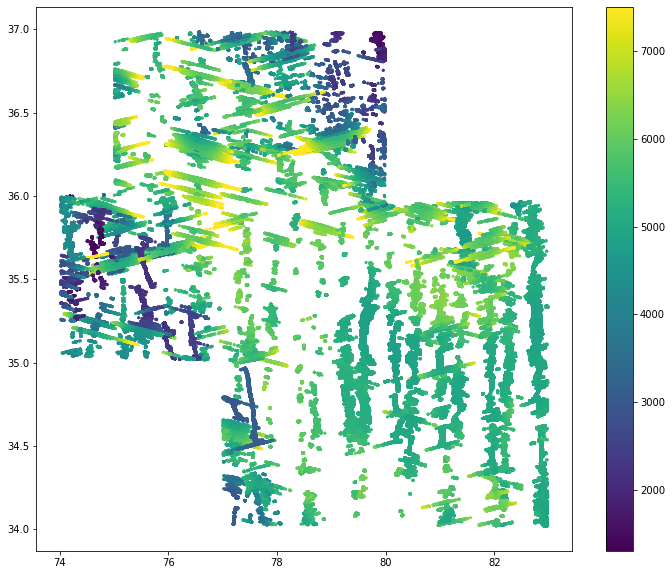

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

## plot with no filters
plt.figure(figsize=(12,10))
plt.scatter(x=df['lon'], y=df['lat'], c=df['elev'], marker='.', s=20, vmax=7500)
plt.colorbar()
plt.show()